In [14]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt


In [20]:
key = jax.random.key(0)

K_true = 4
D = 2
N = 1000
key, subkey = jax.random.split(key)
mu = jax.random.normal(subkey, (K_true,D))

key, subkey = jax.random.split(key)
pi_true = jax.random.dirichlet(subkey, jnp.ones(K_true))
y_labels = jax.random.categorical(subkey, pi_true, shape=(N,))
key, subkey = jax.random.split(key)
sigma_hyper = 0.5
data = jax.random.normal(subkey, (N, D)) * sigma_hyper + mu[y_labels]

In [21]:
from dataclasses import dataclass
from functools import partial

@partial(jax.tree_util.register_dataclass,
         data_fields=('alpha', 'assignments', 'mu', 'pi'),
         meta_fields = ())
@dataclass
class Latent:
    alpha: float
    assignments: jax.Array
    mu: jax.Array
    pi: jax.Array

def gibbs_pi(key, data_NL, latent: Latent):
    counts = jax.numpy.bincount(latent.assignments, length=latent.pi.shape[0])
    pi_new = jax.random.dirichlet(key, counts + latent.alpha)
    return Latent(alpha=latent.alpha, assignments=latent.assignments, mu=latent.mu, pi=pi_new)

def gibbs_mu(key, data_nL, latent: Latent, i: int):
    N = jnp.count_nonzero(latent.assignments == i)
    sigma_sq_posterior = 1/(1 + N / sigma_hyper**2)
    x_sum = jnp.sum(data_nL[latent.assignments == i], axis=0)
    mu_posterior = sigma_sq_posterior / sigma_hyper**2 * x_sum
    mu_new = jax.random.normal(key, (D,)) * jnp.sqrt(sigma_sq_posterior) + mu_posterior
    return Latent(alpha=latent.alpha, assignments=latent.assignments, mu=latent.mu.at[i].set(mu_new), pi=latent.pi)

def gibbs_assignments(key, data_nL, latent: Latent, i:int):
    key, subkey = jax.random.split(key)
    pi = latent.pi
    mu = latent.mu
    z_scores = (data_nL[i] - mu) / sigma_hyper
    logp = jax.scipy.stats.norm.logpdf(z_scores)
    logp = jnp.sum(logp, axis=1)
    log_pi = jnp.log(pi)
    logp = logp + log_pi
    key, subkey = jax.random.split(key)
    assignment = jax.random.categorical(subkey, logp)
    new_assignments = latent.assignments.at[i].set(assignment)  
    return Latent(alpha=latent.alpha, assignments=new_assignments, mu=latent.mu, pi=latent.pi)

def init(key, N, K_max, D):
    key, subkey = jax.random.split(key)
    mu = jax.random.normal(subkey, (K_max,D))
    key, subkey = jax.random.split(key)
    assignments = jax.random.randint(subkey, (N,), 0, K_max)
    pi = jax.random.dirichlet(key, jax.numpy.ones(K_max))
    return Latent(alpha=1.0, assignments=assignments, mu=mu, pi=pi)

## Inference

In [22]:
def gibbs_pi(key, data_nL, latent: Latent):
    counts = jnp.bincount(latent.assignments, length=latent.pi.shape[0])
    concentrations = jnp.concat([counts, jnp.array([latent.alpha])], axis=0)
    pi_new = jax.random.dirichlet(key, concentrations)[:-1]
    return Latent(alpha=latent.alpha, assignments=latent.assignments, mu=latent.mu, pi=pi_new)

def gibbs_mu(key, data_nL, latent: Latent):
    K = latent.mu.shape[0]
    counts = jnp.bincount(latent.assignments, length=K)
    sigma_sq_posterior = 1/(1 + counts / sigma_hyper**2)
    x_sum = jax.ops.segment_sum(data_nL, latent.assignments, K)
    mu_posterior = sigma_sq_posterior.reshape(-1,1) * x_sum / sigma_hyper**2 
    mu_new = jax.random.normal(key, (K,D)) * jnp.sqrt(sigma_sq_posterior).reshape(-1,1) + mu_posterior
    return Latent(alpha=latent.alpha, assignments=latent.assignments, mu=mu_new, pi=latent.pi)

def gibbs_assignments(key, data_nL, latent: Latent):
    log_pi = jnp.log(latent.pi)
    def pdf(x, mu, log_pi):
        z_scores = (x - mu) / sigma_hyper
        log_p = log_pi + jnp.sum(jax.scipy.stats.norm.logpdf(z_scores))
        return log_p

    log_probs = jax.vmap(jax.vmap(pdf, in_axes=(None, 0, 0)), in_axes=(0, None, None))(data_nL, latent.mu, log_pi)
    assignments_new = jax.random.categorical(key, log_probs)
    return Latent(alpha=latent.alpha, assignments=assignments_new, mu=latent.mu, pi=latent.pi)

def gibbs_sweep(key, data, latent):
    key, subkey = jax.random.split(key)
    latent = gibbs_pi(subkey, data, latent)
    latent = gibbs_mu(subkey, data, latent)
    latent = gibbs_assignments(subkey, data, latent)
    return latent

latent = init(key, N, K_true, D)
gibbs_sweep_jit = jax.jit(gibbs_sweep)
gibbs_sweep_jit(key, data, latent)

Latent(alpha=Array(1., dtype=float32, weak_type=True), assignments=Array([2, 2, 2, 1, 2, 0, 2, 3, 1, 1, 2, 1, 3, 0, 0, 0, 0, 1, 2, 2, 0, 2,
       3, 2, 1, 3, 0, 1, 2, 3, 1, 2, 3, 3, 2, 0, 0, 3, 2, 0, 3, 3, 2, 1,
       0, 1, 0, 1, 1, 2, 0, 3, 3, 2, 3, 0, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2,
       2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 3, 2, 0, 3, 0, 3, 0, 2, 0, 0, 0, 1,
       1, 2, 2, 1, 1, 3, 2, 3, 1, 3, 2, 3, 3, 2, 1, 0, 2, 3, 2, 1, 0, 3,
       3, 3, 2, 0, 2, 0, 3, 3, 3, 0, 3, 0, 1, 3, 0, 0, 0, 1, 3, 0, 1, 2,
       3, 1, 2, 3, 1, 0, 0, 1, 0, 1, 2, 2, 2, 2, 1, 1, 3, 2, 3, 1, 0, 0,
       3, 3, 1, 2, 0, 1, 1, 1, 2, 0, 1, 1, 2, 2, 0, 0, 0, 0, 1, 0, 3, 2,
       0, 0, 1, 0, 0, 0, 3, 3, 2, 2, 1, 3, 1, 2, 1, 0, 2, 2, 2, 1, 0, 2,
       2, 2, 2, 2, 0, 3, 0, 0, 1, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 2,
       3, 2, 2, 2, 2, 2, 1, 0, 1, 2, 3, 1, 2, 2, 0, 1, 2, 0, 1, 3, 1, 0,
       1, 0, 2, 3, 2, 2, 2, 0, 1, 2, 3, 0, 2, 2, 2, 3, 3, 2, 3, 3, 1, 1,
       1, 0, 1, 1, 0, 3, 2, 2, 2, 3, 2, 1, 1, 3, 3, 0, 3,

In [23]:
key = jax.random.key(0)
latent = init(key, N, K_true, D)
latent_history = []
for i in range(100):
    key, subkey = jax.random.split(key)
    latent = gibbs_sweep_jit(subkey, data, latent)
    if i % 10 == 0:
        latent_history.append(latent)

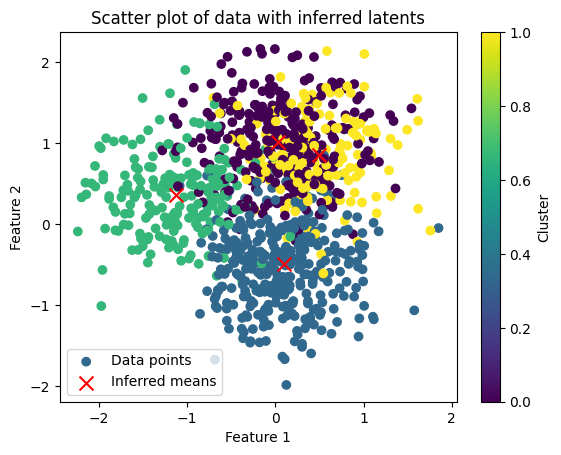

In [24]:
plt.scatter(data[:, 0], data[:, 1], c=latent.assignments, cmap='viridis', alpha=1.0, label='Data points')
plt.scatter(latent.mu[:, 0], latent.mu[:, 1], c='red', marker='x', s=100, label='Inferred means')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter plot of data with inferred latents')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()